In [21]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

import warnings 
warnings.filterwarnings('ignore')

In [4]:
data = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images,test_labels) = data.load_data()

4423680/4422102 [==============================] - 0s 0us/step


### Task one

In [3]:
print(f'training data: {train_images.shape} {train_labels}')
print(f'test data: {test_images.shape} {test_labels}')
print(f'There are {len(np.unique(train_labels))} classes in this dataset and they are {np.unique(train_labels)}')

training data: (60000, 28, 28) [9 0 0 ... 3 0 5]
test data: (10000, 28, 28) [9 2 1 ... 8 1 5]
There are 10 classes in this dataset and they are [0 1 2 3 4 5 6 7 8 9]





Before scaling:


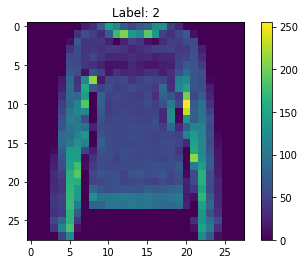

<Figure size 432x288 with 0 Axes>

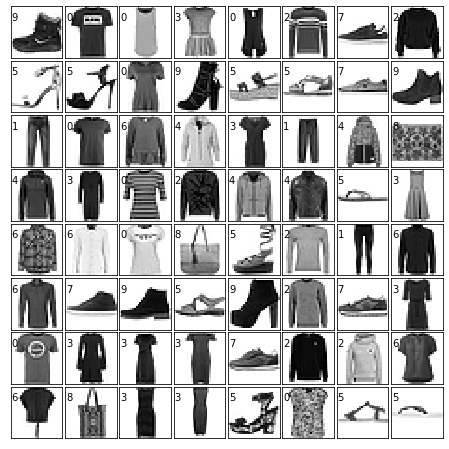

In [4]:
# visualizing an data point
print('\n\n\nBefore scaling:')
plt.clf()
plt.imshow(train_images[400])
plt.title(f'Label: {train_labels[400]}')
plt.colorbar()

plt.show()

plt.clf()
fig = plt.figure(figsize=(6,6))
# Adjust the subplots

fig.subplots_adjust(left = 0, right = 1, bottom = 0, top=1, hspace=0.05, wspace=0.05)

# For each of the 64 images
for i in range(64):

  # Initialize the subplots: add a subplot in the grid of 8 by 8, at i+1-th position
  ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[])

  # Display an image at the i-th position

  ax.imshow(train_images[i], cmap=plt.cm.binary, interpolation='nearest')

  # Label the image with the target value

  ax.text(0, 7, str(train_labels[i]))

plt.show()




### Task Two

> 90.575
> 90.908
> 90.875
> 91.008
> 90.233


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


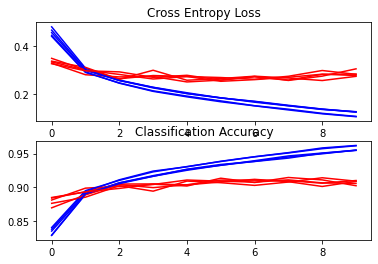

Accuracy: mean=90.720 std=0.283, n=5


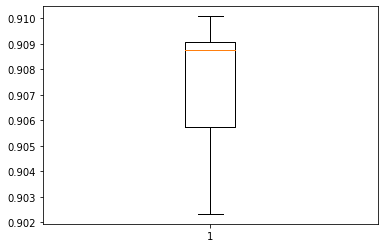

In [5]:
### Baseline model
def load_dataset():  
  data = keras.datasets.fashion_mnist
  (train_images, train_labels), (test_images,test_labels) = data.load_data()
  # reshape dataset to have a single channel
  train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
  test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

  # one-hot encode the target variables
  train_labels = tf.keras.utils.to_categorical(train_labels)
  test_labels = tf.keras.utils.to_categorical(test_labels)
  return train_images, train_labels, test_images, test_labels

# scale pixels
def pixels_scaled(train, test):
	# convert from integers to floats
	train_images = train.astype('float32')
	test_images = test.astype('float32')
 
 	# normalize to range 0-1
	train_images = train_images / 255.0
	test_images = test_images / 255.0
	# return normalized images
	return train_images, test_images

# define cnn model
def define_model():
	model = tf.keras.models.Sequential()
 
 # vanila neural network
	model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(tf.keras.layers.MaxPooling2D((2, 2)))
	model.add(tf.keras.layers.Flatten())
	model.add(tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(tf.keras.layers.Dense(10, activation='softmax'))
	# compile model
	opt = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# append scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		plt.subplot(211)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='red', label='test')
		# plot accuracy
		plt.subplot(212)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='red', label='test')
	plt.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
	# box and whisker plots of results
	plt.boxplot(scores)
	plt.show()
 
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	train_images, train_labels, test_images, test_labels = load_dataset()
	# prepare pixel data
	train_images, test_images = pixels_scaled(train_images, test_images)
	# evaluate model
	scores, histories = evaluate_model(train_images, train_labels)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)
 
# entry point, run the test harness
run_test_harness()

### Improving the model

> 91.450
> 91.533
> 91.558
> 91.125
> 91.450


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


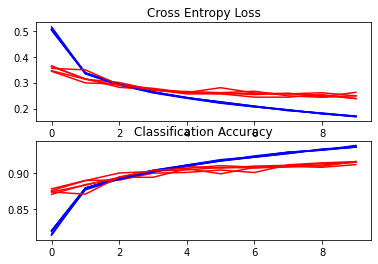

Accuracy: mean=91.423 std=0.155, n=5


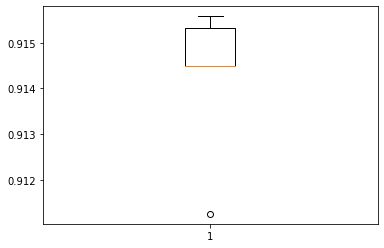

In [17]:
### Optimized model
def load_dataset():  
  data = keras.datasets.fashion_mnist
  (train_images, train_labels), (test_images,test_labels) = data.load_data()
  # reshape dataset to have a single channel
  train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
  test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

  # one-hot encode the target variables
  train_labels = tf.keras.utils.to_categorical(train_labels)
  test_labels = tf.keras.utils.to_categorical(test_labels)
  return train_images, train_labels, test_images, test_labels

# scale pixels
def pixels_scaled(train, test):
	# convert from integers to floats
	train_images = train.astype('float32')
	test_images = test.astype('float32')
 
 	# normalize to range 0-1
	train_images = train_images / 255.0
	test_images = test_images / 255.0
	# return normalized images
	return train_images, test_images

# define cnn model
def define_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(28, 28, 1)))
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))

  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))
  # compile model
  opt = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# append scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		plt.subplot(211)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='red', label='test')
		# plot accuracy
		plt.subplot(212)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='red', label='test')
	plt.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
	# box and whisker plots of results
	plt.boxplot(scores)
	plt.show()
 
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	train_images, train_labels, test_images, test_labels = load_dataset()
	# prepare pixel data
	train_images, test_images = pixels_scaled(train_images, test_images)
	# evaluate model
	scores, histories = evaluate_model(train_images, train_labels)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)
 
# entry point, run the test harness
run_test_harness()

### Saving the model for later use

In [5]:
### Optimized model
def load_dataset():  
  data = keras.datasets.fashion_mnist
  (train_images, train_labels), (test_images,test_labels) = data.load_data()
  # reshape dataset to have a single channel
  train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
  test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

  # one-hot encode the target variables
  train_labels = tf.keras.utils.to_categorical(train_labels)
  test_labels = tf.keras.utils.to_categorical(test_labels)
  return train_images, train_labels, test_images, test_labels

# scale pixels
def pixels_scaled(train, test):
	# convert from integers to floats
	train_images = train.astype('float32')
	test_images = test.astype('float32')
 
 	# normalize to range 0-1
	train_images = train_images / 255.0
	test_images = test_images / 255.0
	# return normalized images
	return train_images, test_images

# define cnn model
def define_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(28, 28, 1)))
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))

  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))
  # compile model
  opt = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

 
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	train_images, train_labels, test_images, test_labels = load_dataset()
	# prepare pixel data
	train_images, test_images = pixels_scaled(train_images, test_images)
 
	model = define_model()
  # fit model
	model.fit(train_images, train_labels, epochs=10, batch_size=32, verbose=0)
	# save model
	model.save('final_model.h5')
 
# entry point, run the test harness
run_test_harness()

### Predicting images

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
 
# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, color_mode = "grayscale", target_size=(28, 28))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 1 channel
	img = img.reshape(1, 28, 28, 1)
	# prepare pixel data
	img = img.astype('float32')
	img = img / 255.0
	return img
 
# load an image and predict the class
def run_example():
  # load the image
  img = load_image('/content/drive/MyDrive/Colab_Notebooks/Hamoye/hamoye_NN/sample_image.png')
  # load model
  model = load_model('final_model.h5')
  # predict the class
  result = np.argmax(model.predict(img), axis=-1)
  print(result)

  for k in range(len(result)):
    if result[k] == 0:
      print('Tops', end = '')
    elif result[k] == 1:
      print('Trousers', end = '')
    elif result[k] == 2:
      print('Pullover', end = '')
    elif result[k] == 3:
      print('Dress', end = '')
    elif result[k] == 4:
      print('Coat', end = '')
    elif result[k] == 5:
      print('Sandal', end = '')
    elif result[k] == 6:
      print('Shirt', end = '')
    elif result[k] == 7:
      print('Sneaker', end = '')
    elif result[k] == 8:
      print('Bag', end = '')
    elif result[k] == 9:
      print('Ankle boot', end = '')
 
# entry point, run the example
run_example()

[2]
Pullover